In [0]:
import pandas as pd
import seaborn as sns
import numpy as np
import warnings
from tqdm import tqdm
from scipy.stats import chi2_contingency
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.metrics import accuracy_score,f1_score,recall_score,average_precision_score
from sklearn.metrics import precision_score,precision_recall_curve,auc
from matplotlib import pyplot as plt
from datetime import datetime

warnings.filterwarnings('ignore')

%matplotlib inline

sns.set()

df = pd.read_csv("https://docs.google.com/spreadsheets/d/1rOlD505qjhEVApCaYwkM-5JW7RCmA8DVBx0iuWoRZak/export?format=csv&id=1rOlD505qjhEVApCaYwkM-5JW7RCmA8DVBx0iuWoRZak&gid=430957318")

#**Exploring the data**

Before we build any machine learning model we need to take a deep dive into the dataset to build intution and see if we can create any new features.

In [0]:
# Used Road Safety Data Guide to understand the target variable and encode it to something more intuitive

df['Did_Police_Officer_Attend_Scene_of_Accident'] = df['Did_Police_Officer_Attend_Scene_of_Accident'].apply(lambda x: 1 if x == 1 else 0)

print(df.nunique())

Accident_Index                                 146321
Location_Easting_OSGR                           92575
Location_Northing_OSGR                          96296
Longitude                                      138878
Latitude                                       137376
Police_Force                                       51
Accident_Severity                                   3
Number_of_Vehicles                                 14
Number_of_Casualties                               26
Date                                              365
Day_of_Week                                         7
Time                                             1439
Local_Authority_(District)                        380
Local_Authority_(Highway)                         207
1st_Road_Class                                      6
1st_Road_Number                                  4384
Road_Type                                           6
Speed_limit                                         6
Junction_Detail             

After a quick look i can see continuous variables,categorical variables and ordinal variables. These need to be treated differently. Some features seem redudant mainly the location and district data. At first i thought the longitude and latitude data could have have an impact on wether a police officer attended because of how far away the distance would be from the nearest police force, however this information is already captured within the Urban_or_Rural_Area feature but we explore this further later on.


So i will remove the redudant variables.

In [0]:
df = df.drop(['Location_Easting_OSGR', 'Location_Northing_OSGR',
               'Accident_Index', 'Local_Authority_(District)',
               'Local_Authority_(Highway)', 'LSOA_of_Accident_Location',
               '1st_Road_Number', '2nd_Road_Number' ], axis=1)

df.head()


,Longitude,Latitude,Police_Force,Accident_Severity,Number_of_Vehicles,Number_of_Casualties,Date,Day_of_Week,Time,1st_Road_Class,Road_Type,Speed_limit,Junction_Detail,Junction_Control,2nd_Road_Class,Pedestrian_Crossing-Human_Control,Pedestrian_Crossing-Physical_Facilities,Light_Conditions,Weather_Conditions,Road_Surface_Conditions,Special_Conditions_at_Site,Carriageway_Hazards,Urban_or_Rural_Area,Did_Police_Officer_Attend_Scene_of_Accident
0,-0.206443,51.496345,1,3,2,1,09/01/2014,5,13:21,3,6,30,0,-1,-1,0,0,1,2,2,0,0,1,0
1,-0.189713,51.489523,1,3,2,1,20/01/2014,2,23:00,3,6,30,5,4,3,0,5,7,1,1,0,0,1,0
2,-0.173827,51.490536,1,3,2,1,21/01/2014,3,10:40,3,6,30,3,4,6,0,0,1,1,1,0,0,1,1
3,-0.192311,51.496668,1,3,1,1,15/01/2014,4,17:45,5,6,30,3,4,6,0,1,4,1,1,0,0,1,0
4,-0.171308,51.495892,1,3,2,1,09/01/2014,5,08:50,3,6,30,7,4,3,0,8,1,1,1,0,0,1,1


Now that the data has been cleaned we can observe the distribution of police attending scenes of accidents throughout the country




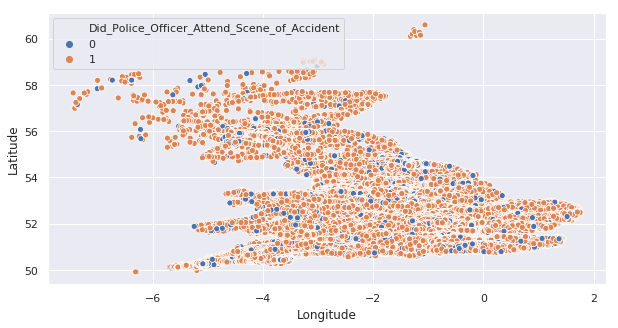

In [0]:
plt.figure(figsize=(10, 5))

sns.scatterplot(x='Longitude',y='Latitude',hue='Did_Police_Officer_Attend_Scene_of_Accident',data=df)
plt.legend(loc='best')

plt.show()

I can not see any patterns within the Longitude and Latitude data. There seems to be an even distribution of whether officers will attend  the scenes of accidents or not throughout the country. Unlikely to get any useful information from this feature for modelling purposes. Will drop to reduce dimensionality

Lets futher explore the data to determine any patterns.

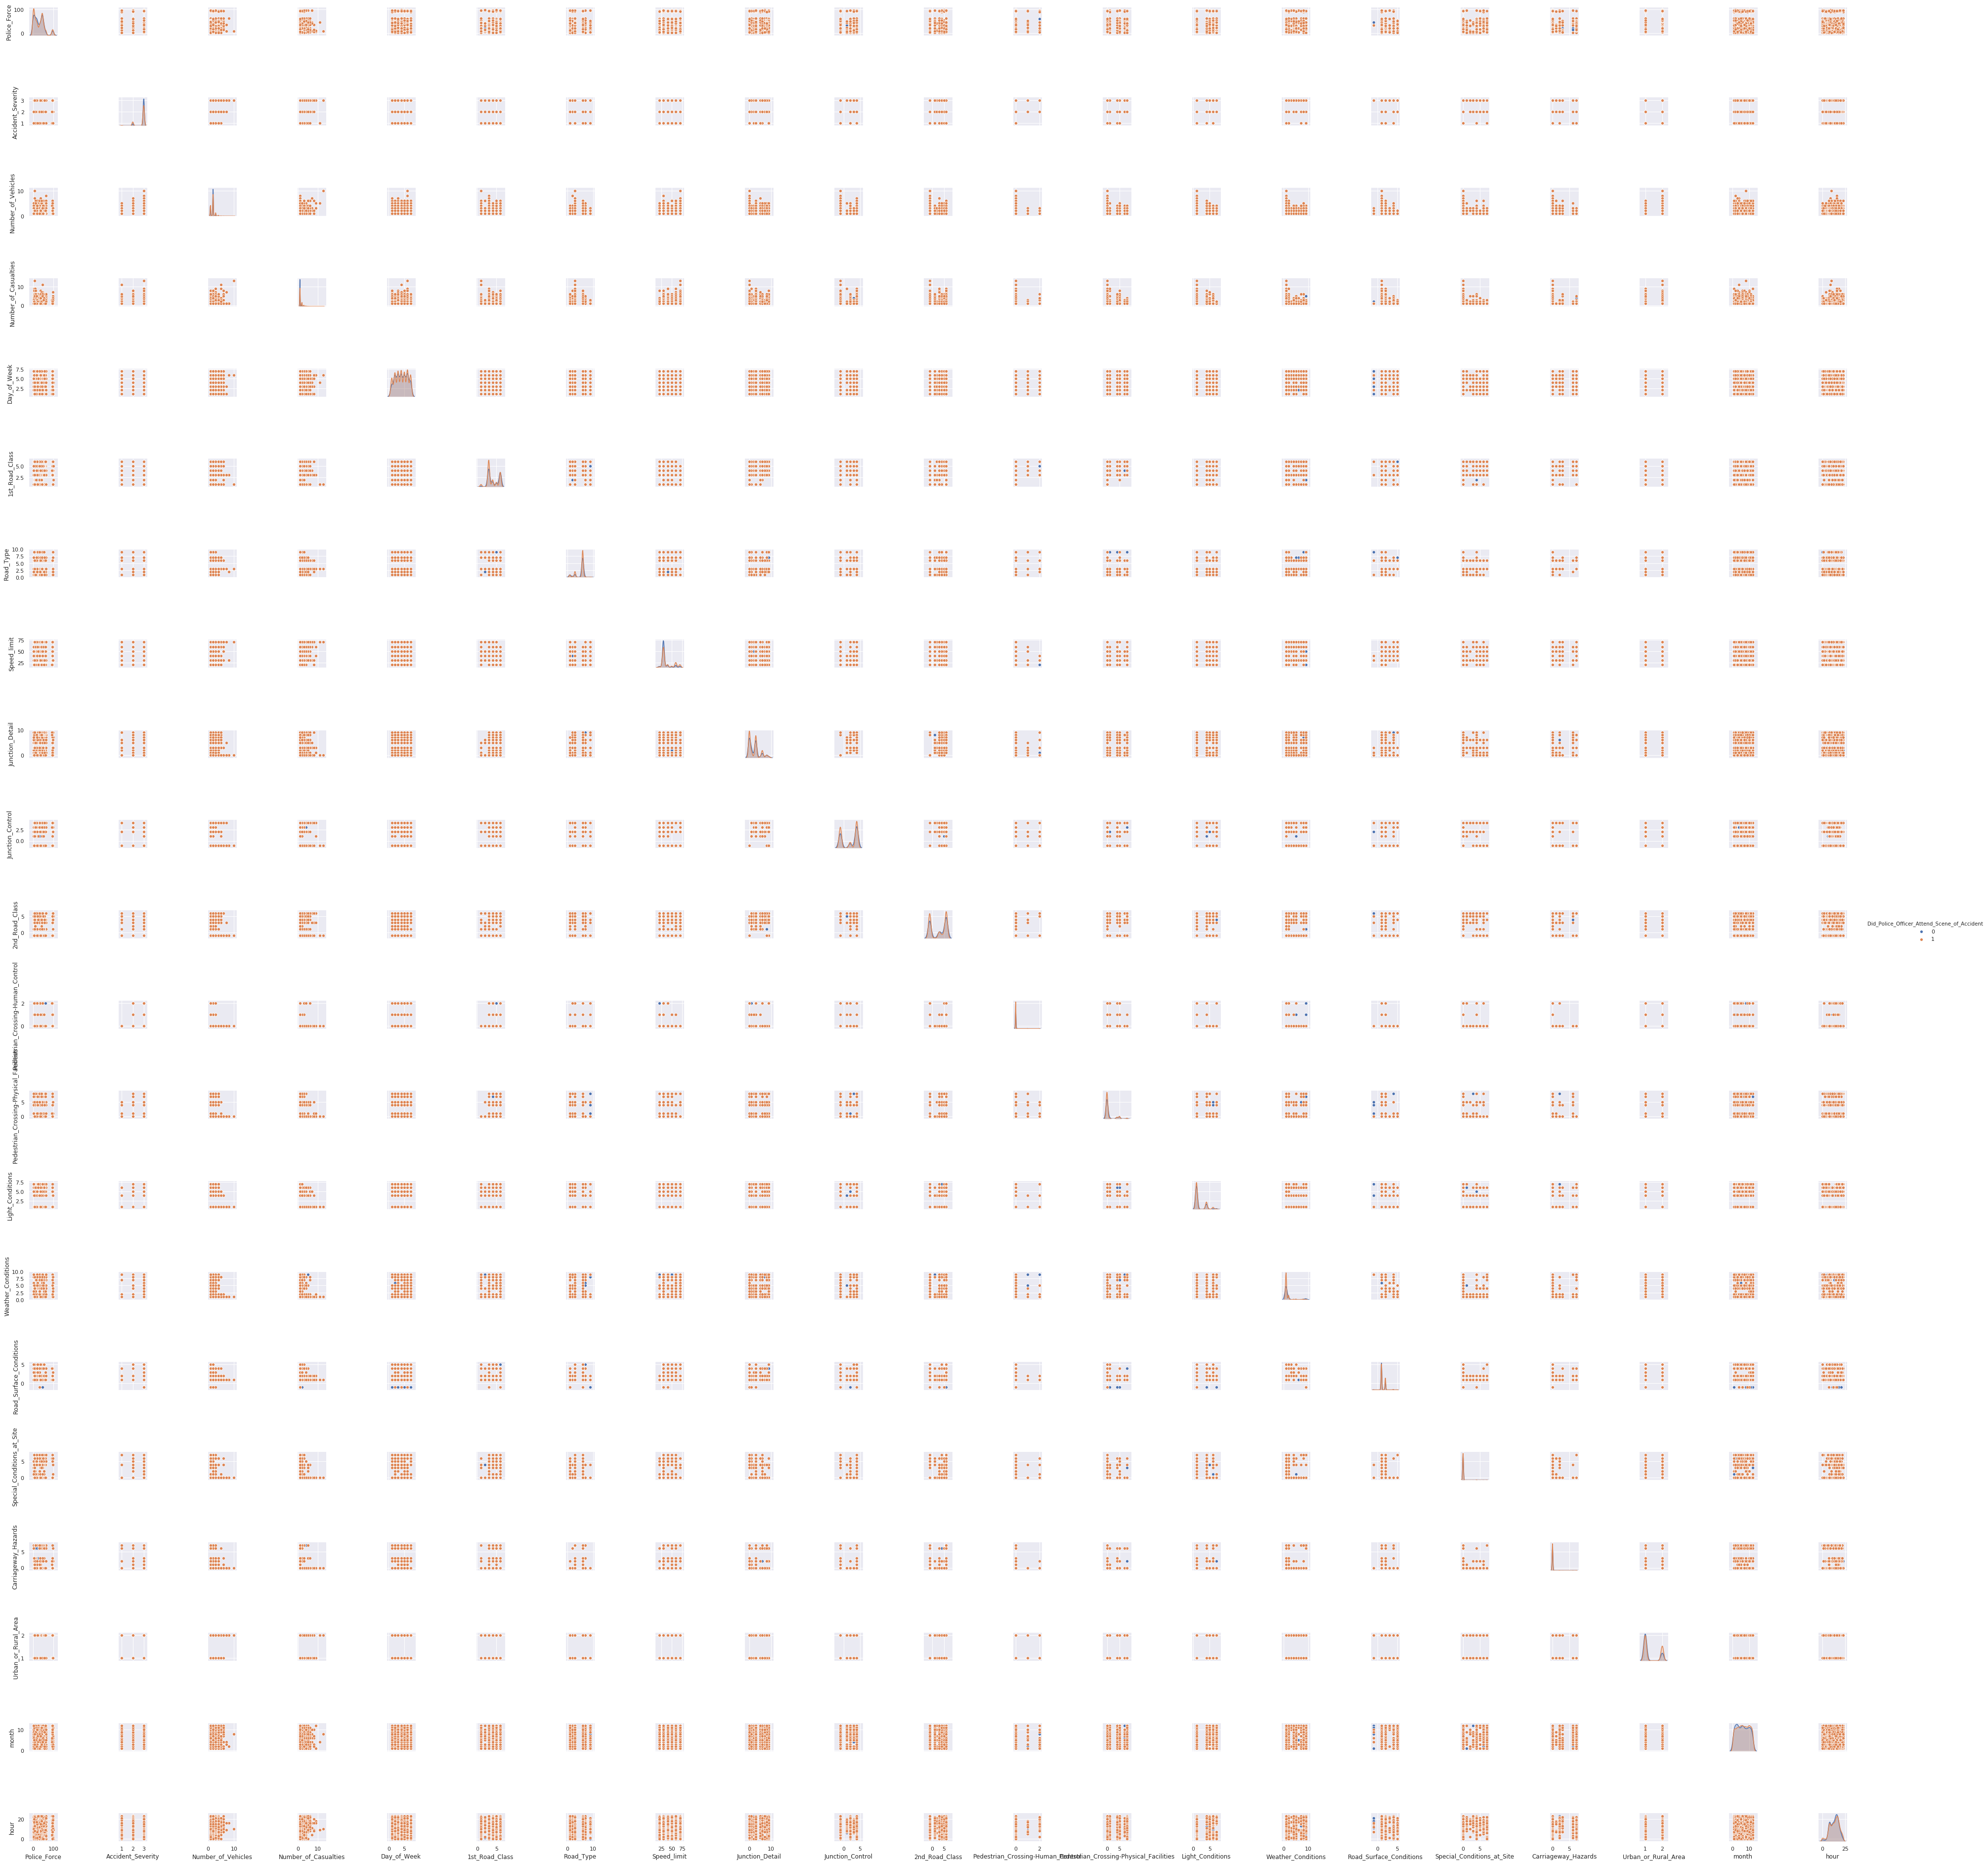

In [0]:
df['Date'] = pd.to_datetime(df['Date'])

# Create two new features for Month and Hour

df['month'] = df['Date'].dt.month

df['hour'] = df['Time'].str[:2]

df['hour'] = df['hour'].astype(int)

df = df.drop(['Date', 'Time','Longitude','Latitude'], axis=1)

# Necessary to specify columns excluding target variable due to error within seaborn when plotting KDE.

plot_columns = list(df)
plot_columns.remove('Did_Police_Officer_Attend_Scene_of_Accident')
pairplot_columns = plot_columns

# Plots may appear differently to observations made on whole dataset as this is a sample to speed up computation

sns.pairplot(df.sample(10000),vars=pairplot_columns,hue = 'Did_Police_Officer_Attend_Scene_of_Accident' )

plt.show()

#Analysis of Pair Plots

Observing the plots it is difficult to see any patterns as the positive class is masking the negative class. 

There are however a few relationships that immediately stand out whilst viweing the diagonal KDE plots. Police forces around 85 and above are more likely to attend an accident scene. Using the Road Safety Data Guide i discovered these are Scottish police forces. 

There is a little peak for police officers attending scenes of accidents on Saturdays. This could be because there are being more accidents on that day.

Police officers are more likely to attend scenes of accidents if 1st Road Class is 4 and above
which correspond to B road, C roads and Unclassified Roads. This makes sense as these type of roads are slower and more easily accessible for police officers.Also the case for 2nd Road Class. This could be useful in building a features.

Suprisingly the higher the speed limit the less likely police officers are to attend the scene of an accident. This could be because police officers remit ends and a separate force is responsible.

Junction detail and Junction Control also seem to have an impact on the likelihood of police attending the scene. With a value of 5 and above for Junction detail and 3 and above for Junction Control. These might be just by random chance as i cant see any valid reason for this. However i can still create a feature out of this.

It appears the less light there is at that scene of accident the less likely police are to attend. With anything above 4 seeing sharp increase in police not attending. This corresponds to darkness and no light. Which makes alot of sense as police would not like to make the situation worse .

Police officers are also less likely to attend to the scence if the Road Surface Conditions are adverse. 

Police officers are less likely to attend the scene if there is oil or diesel within the site this corresponds to special site conditions. Again this is most likely to avoid making the situation worse through further accidents.

Also police officers are more likely to attend the scene of an accident if it happened within 50 metres of a crossing that was controlled by someone. This makes sense as it could be children or  impaired people crossing.

One final observation is that  police officers are less likely to attend the scene of the accident if its within a rural area.

Lets explore some of these features further to gain even more insight.

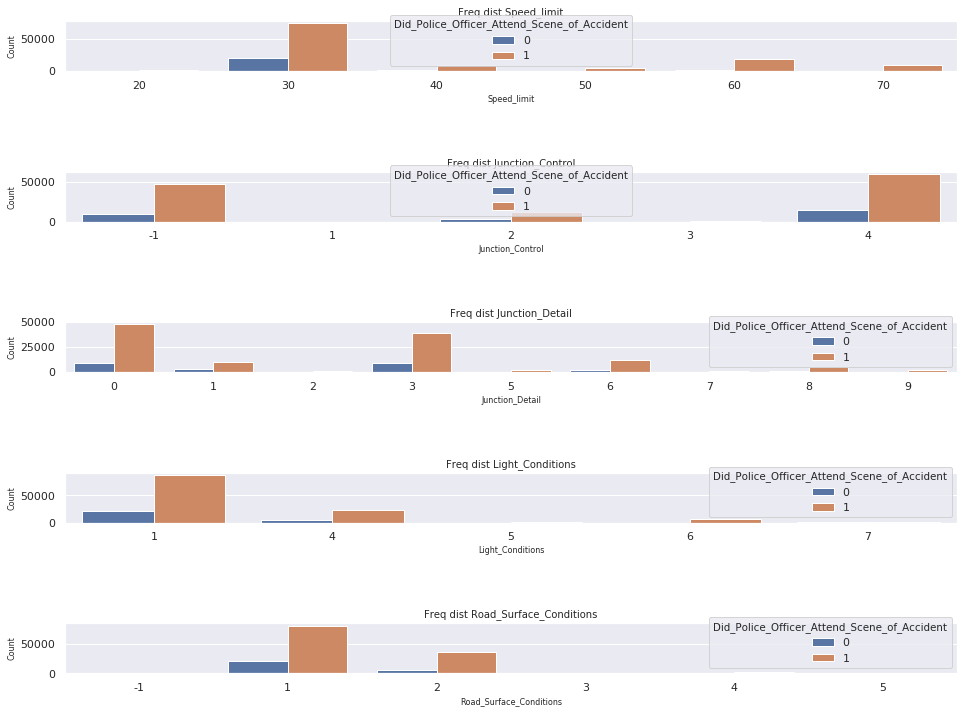

In [0]:
col_names = ['Speed_limit','Junction_Control',
             'Junction_Detail','Light_Conditions','Road_Surface_Conditions']

fig, ax = plt.subplots(len(col_names), figsize=(16,12))

for i, col in enumerate(col_names):

    sns.countplot(df[col],hue=df['Did_Police_Officer_Attend_Scene_of_Accident'],ax=ax[i])
    ax[i].set_title('Freq dist '+col, fontsize=10)
    ax[i].set_xlabel(col, fontsize=8)
    ax[i].set_ylabel('Count', fontsize=8)
    
plt.subplots_adjust(hspace = 2.0)

plt.show()

These count plots has allowed us to view the data more objectively and confirmed our assumptions of some of the features like higher speed limits tending to have less police officers attending the scence of the accident.

And less police officers attending accidents with dark conditions.

We can now create features based on these insights to increase the predictive power of the model.

We arent left with any continous variables so we dont need to worry about outliers in this case. 

# Visualising the target variable

Lets have a look at the target variable

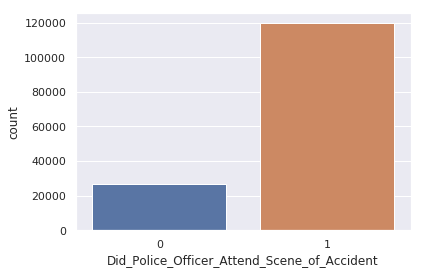

In [0]:
sns.countplot(x=df['Did_Police_Officer_Attend_Scene_of_Accident'])

plt.show()

Looking at this we can see that the dataset is  imblanced with around 30000 being in the negative class with 120000 in the positive.

The imbalance is favoured towards the positive class . If it was the other way around we could have used a variety of methods to overcome this issue. 

One would be to select an algorithm that can deal with this imbalance. Another method would be to change the metric and instead of using accuracy which would give incorrect outputs we can use f1 score or Matthews correlation coefficient which are suited for imbalanced datasets. 

The other methods that are available to use are Undersampling and Oversampling. Or even a combination of both

Lets create a basline model based on these features.

#**Baseline Model**

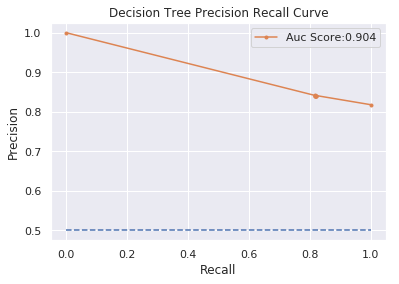

The f1 score for the baseline model is 0.8297144405677315, Precision: 0.8411978844700873, Recall: 0.8185403020986499


In [0]:
baseline_df = df.copy()

baseline_df.head()

X = baseline_df.drop('Did_Police_Officer_Attend_Scene_of_Accident',axis = 1)

y = baseline_df.Did_Police_Officer_Attend_Scene_of_Accident

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.25,random_state=42)

tree = DecisionTreeClassifier()

tree.fit(X_train,y_train)

y_pred = tree.predict(X_test)

proba_tree = tree.predict_proba(X_test)

probs_tree = proba_tree[:, 1]

precision, recall, thresholds = precision_recall_curve(y_test, probs_tree)

auc_score = auc(recall, precision)

f1_scorer = f1_score(y_test,y_pred)
precision_scorer = precision_score(y_test,y_pred)
recall_scorer = recall_score(y_test,y_pred)

plt.plot([0, 1], [0.5, 0.5], linestyle='--')

plt.plot(recall, precision, marker='.',label="Auc Score:{}".format(round(auc_score,3)))

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Decision Tree Precision Recall Curve")
plt.legend(loc='best')
plt.show()

print(f"The f1 score for the baseline model is {f1_scorer}, Precision: {precision_scorer}, Recall: {recall_scorer}")


We used F1 score to determine the basline metric. And we also plotted the precision-recall curve as opposed to the ROC curve due to the class imbalance. These results are not bad at all for a baseline but i believe we can do better by creating features and selecting more powerful algorithms.

#**Feature Generation**

In [0]:
class feature_generation():

    def is_saturday(self,day):
        if day == 6:
            return 1
        else:
            return 0
    
    def is_scottish_police(self,force):
        if force > 85:
            return 1
        else:
            return 0
    
    def is_class_b_or_c(self,classes):
        if classes > 4:
            return 1
        else:
            return 0
    
    def junction_detail_feature(self,detail):
        if detail >= 5:
            return 1
        else:
            return 0
    
    def junction_control_feature(self,control):
        if control >= 3:
            return 1
        else:
            return 0

    def is_high_speed_limit(self,speed):
        if speed >= 50:
            return 1
        else:
            return 0
    
    def is_no_light(self,darkness):
        if darkness > 4:
            return 1
        else:
            return 0
    
    def is_bad_conditions(self,condition):
        if condition > 5:
            return 1
        else:
            return 0
    
    def near_controlled_crossing(self,crossing):
        if crossing >= 1:
            return 1
        else:
            return 0
                    
generate_features = feature_generation()  

  
df['is_scottish_police'] = df['Police_Force'].apply(generate_features.is_scottish_police)

df['is_saturday'] = df['Day_of_Week'].apply(generate_features.is_saturday)

df['1st_class_b_or_c'] = df['1st_Road_Class'].apply(generate_features.is_class_b_or_c)

df['2nd_class_b_or_c'] = df['2nd_Road_Class'].apply(generate_features.is_class_b_or_c)

df['junction_detail_feature'] = df['Junction_Detail'].apply(generate_features.junction_detail_feature)

df['junction_control_feature'] = df['Junction_Control'].apply(generate_features.junction_control_feature)

df['is_high_speed_limit'] = df['Speed_limit'].apply(generate_features.is_high_speed_limit)

df['dark_conditions']  = df['Light_Conditions'].apply(generate_features.is_no_light)

df['bad_road_condition'] = df['Road_Surface_Conditions'].apply(generate_features.is_bad_conditions)

df['bad_site_condition'] = df['Special_Conditions_at_Site'].apply(generate_features.is_bad_conditions)

df['near_controlled_crossing'] = df['Pedestrian_Crossing-Human_Control'].apply(generate_features.near_controlled_crossing)

Now that we have created a few more features the dimensionality of the dataset has increased. Lets perform some statistical tests to determine if all of these categorical features are needed.



#**Statistical Test**

In [0]:
 def chisquaretest(df,col,target, alpha=0.01):
        X = df[col].astype(str)
        Y = df[target].astype(str)
        
        observed = pd.crosstab(Y,X) 
        
        chi2, p, dof, expected = chi2_contingency(observed.values)
     
        if  p < alpha:
            print(f"{col} is IMPORTANT for Prediction")
        else:
            print(f"{col} is NOT an important predictor. (Discard {col} from dataset)")
            
columns = ['1st_Road_Class','Road_Type','Speed_limit','Junction_Detail','Junction_Control',
           '2nd_Road_Class','near_controlled_crossing','is_scottish_police','is_saturday','is_high_speed_limit','1st_class_b_or_c','2nd_class_b_or_c',
          'junction_detail_feature','junction_control_feature','dark_conditions','bad_road_condition','bad_site_condition','Day_of_Week',
          'Light_Conditions','Weather_Conditions','Road_Surface_Conditions','Special_Conditions_at_Site','Carriageway_Hazards',
           'Pedestrian_Crossing-Human_Control','Pedestrian_Crossing-Physical_Facilities','hour','month'] 

for col in columns:
    chisquaretest(df,col,'Did_Police_Officer_Attend_Scene_of_Accident')

1st_Road_Class is IMPORTANT for Prediction
Road_Type is IMPORTANT for Prediction
Speed_limit is IMPORTANT for Prediction
Junction_Detail is IMPORTANT for Prediction
Junction_Control is IMPORTANT for Prediction
2nd_Road_Class is IMPORTANT for Prediction
near_controlled_crossing is NOT an important predictor. (Discard near_controlled_crossing from dataset)
is_scottish_police is IMPORTANT for Prediction
is_saturday is NOT an important predictor. (Discard is_saturday from dataset)
is_high_speed_limit is IMPORTANT for Prediction
1st_class_b_or_c is IMPORTANT for Prediction
2nd_class_b_or_c is NOT an important predictor. (Discard 2nd_class_b_or_c from dataset)
junction_detail_feature is IMPORTANT for Prediction
junction_control_feature is IMPORTANT for Prediction
dark_conditions is IMPORTANT for Prediction
bad_road_condition is NOT an important predictor. (Discard bad_road_condition from dataset)
bad_site_condition is IMPORTANT for Prediction
Day_of_Week is IMPORTANT for Prediction
Light_Con

Due to the large amount features already in the dataset, i ran the chi square test with a 0.01 significance level meaning we will only reject the null hypothesis that there is no relationship between the variables if the p value is less than 0.01.

Lets fit these features to more poweful algorithms and observe if this improves the score.

#**Model Comparison**

In [0]:
model_df = df.copy()

# Police force was also dropped as one hot encoding this feature increased processing times whilst providing little to no benefit.

model_df = model_df.drop(['near_controlled_crossing','is_saturday','2nd_class_b_or_c',
              'bad_road_condition','Pedestrian_Crossing-Human_Control','Police_Force'],axis=1)

# One hot encode categorical features

columns_list = ['1st_Road_Class','Road_Type',
                'Junction_Detail','Junction_Control','2nd_Road_Class','Pedestrian_Crossing-Physical_Facilities',
                'Weather_Conditions','Road_Surface_Conditions','Special_Conditions_at_Site','Carriageway_Hazards','Day_of_Week'] 

for cols in columns_list:
   model_df[cols]=model_df[cols].astype('category')
    
model_df = pd.get_dummies(model_df, columns=columns_list)


# Fitting and comparing models

X = model_df.drop('Did_Police_Officer_Attend_Scene_of_Accident',axis = 1)

y = model_df.Did_Police_Officer_Attend_Scene_of_Accident

scoring = ['precision', 'recall', 'f1']

models = []
models.append(('RF', RandomForestClassifier()))
models.append(('ADA', AdaBoostClassifier()))
models.append(('XGB', XGBClassifier()))

results=[]
names = []

for name, model in tqdm(models):
  kfold = KFold(n_splits=5, random_state=42)
  cv_results = cross_validate(model, X, y, cv=kfold,scoring=scoring)
  results.append(cv_results)
  names.append(name)
  print(f"{name}, {cv_results['test_recall'].mean()},{cv_results['test_precision'].mean()},{cv_results['test_f1'].mean()}")


 33%|███▎      | 1/3 [00:19<00:39, 19.60s/it]

RF, 0.8994586114962442,0.8336495083995052,0.8649122360506192


 67%|██████▋   | 2/3 [01:23<00:32, 32.75s/it]

ADA, 0.9919153556737743,0.8240523093519926,0.9001333726579638


100%|██████████| 3/3 [04:05<00:00, 71.62s/it]

XGB, 0.9941206237039772,0.8230864406344965,0.9004795788411638


As expected more powerful algorithms combined with feature generation provided an increase in metrics including  F1 score.

The untuned Adaboost and Xgboost have very similar metrics ultimately i decided to use XGboost as the algorithm is more robust and recall is slightly higher. Assuming this model is to be used to determine if officers should be sent to the scene of an accident. Lower false negative means police resource being used efficently.

#**Final Model**

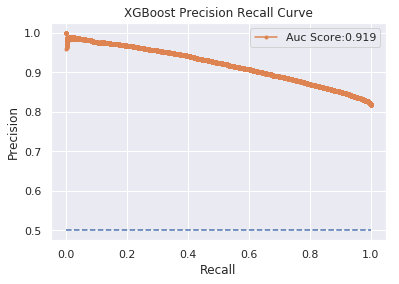

The f1 score for the Xgboost model is 0.9012241185462171, Precision: 0.8245301772959478, Recall: 0.9936486712351663


In [0]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_state=42)

# Parameters tuned using GridSearchCV

xgb = XGBClassifier(silent=0,colsample_bytree= 0.9,gamma=0.5,learning_rate=0.1
                    ,max_depth=6,min_child_weight=6,subsample=1)

xgb.fit(X_train,y_train)

y_pred = xgb.predict(X_test)

f1_scorer = f1_score(y_test,y_pred)
precision_scorer = precision_score(y_test,y_pred)
recall_scorer = recall_score(y_test,y_pred)

probs = xgb.predict_proba(X_test)

probs = probs[:, 1]

precision, recall, thresholds = precision_recall_curve(y_test, probs)

auc_score = auc(recall, precision)

plt.plot([0, 1], [0.5, 0.5], linestyle='--')

plt.plot(recall, precision, marker='.',label="Auc Score:{}".format(round(auc_score,3)))

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("XGBoost Precision Recall Curve")
plt.legend(loc='best')
plt.show()

print(f"The f1 score for the Xgboost model is {f1_scorer}, Precision: {precision_scorer}, Recall: {recall_scorer}")

The Metrics have increased. We now have an F1 Score of 0.9 and Recall of 0.99 suggesting very few false negatives.  Recall is still high but has decreased from the baseline.

Overall the AUC, F1 score and Recall have all improved and i am confident that the output of this model is can be trusted.

Finally lets have a look at some of the most important features in this model

#**Feature Importance**

In [0]:

feature_importances = pd.DataFrame(xgb.feature_importances_, index = X_train.columns, columns=['importance']).sort_values('importance', ascending=False)

print(feature_importances.head(20))

                            importance
is_high_speed_limit           0.204739
Speed_limit                   0.099561
Weather_Conditions_9          0.059644
Accident_Severity             0.043754
Number_of_Casualties          0.033615
Road_Surface_Conditions_2     0.026382
Junction_Detail_1             0.026051
Road_Surface_Conditions_-1    0.024399
Number_of_Vehicles            0.020672
Junction_Detail_6             0.018393
1st_Road_Class_6              0.017898
2nd_Road_Class_-1             0.013742
Road_Surface_Conditions_1     0.013472
Light_Conditions              0.012777
2nd_Road_Class_6              0.012399
Weather_Conditions_4          0.011731
Day_of_Week_1                 0.011572
2nd_Road_Class_3              0.010659
Road_Type_9                   0.009719
dark_conditions               0.008724


Suprisingly the feature i created for wether the speed is high (>=50 mph) is the most important for this model. I believe this is due to underlying reasons i discussed earlier on. Perhaps police forces remit ends at motorways and the jurisdiction lies with highways england police officers.

Dark conditions another feature i created also ended up in the top 20 which makes intuitive sense as officers would try to limit further accidents by attending well lit areas.